#### Script to diagnose and plot Buoyancy metric from Ahmed et al. 2020.

James Ruppert  
jruppert@ou.edu  
7/15/23

In [15]:
from netCDF4 import Dataset
import numpy as np
# matplotlib.use('pdf')
import matplotlib.pyplot as plt
from matplotlib import colors, ticker, rc
import pandas as pd
from precip_class import precip_class
from cfads_functions import mask_edges
from thermo_functions import esat, mixr_from_e
from write_ncfile import write_ncfile

In [16]:
# #### Main settings

# NOTE: Using copied tracking from CTL for NCRF tests

storm = 'haiyan'
# storm = 'maria'

# How many members
nmem = 10 # number of ensemble members
# nmem = 2

filename_out='buoy.nc'

# #### Directories

figdir = "/home/jamesrup/figures/tc/ens/time_series/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"

# Tests to read and compare
ntest=2
if storm == 'haiyan':
    tests = ['ctl','ncrf36h']
elif storm == 'maria':
#        tests = ['ctl','ncrf36h']
    tests = ['ctl','ncrf48h']

In [17]:
# Prep tests & ens members

def get_tshift(itest):
    if itest == 'ctl':
        tshift=0
    elif itest == 'ncrf36h':
        tshift=36
    elif itest == 'ncrf48h':
        tshift=48
    return tshift

# Ens member strings
memb0=1 # Starting member to read
nums=np.arange(memb0,nmem+memb0,1)
nums=nums.astype(str)
nustr = np.char.zfill(nums, 2)
memb_all=np.char.add('memb_',nustr)

datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'
varfil_main = Dataset(datdir+'post/d02/T.nc')
pres = varfil_main.variables['pres'][...]
pres = pres.data
nx1 = varfil_main.dimensions['lat'].size
nx2 = varfil_main.dimensions['lon'].size
varfil_main.close()
nz=pres.shape[0]
dp = (pres[0]-pres[1])*1e2 # Pa

nt = np.zeros(ntest, dtype=np.int32)
for itest in range(ntest):
    ##### Get dimensions
    datdir = main+storm+'/'+memb_all[0]+'/'+tests[itest]+'/'
    varfil_main = Dataset(datdir+'post/d02/T.nc')
    i_nt = varfil_main.dimensions['time'].size
    varfil_main.close()
    nt[itest]=i_nt

In [51]:
dims2d = (i_nt,nx1,nx2)
dims3d = (i_nt,nz,nx1,nx2)
dims2d_names = ('nt','nx1','nx2')
dims3d_names = ('nt','nz','nx1','nx2')

dims_set = [
    [dims3d,dims3d_names],
    [dims2d,dims2d_names],
    [dims2d,dims2d_names],
    [dims2d,dims2d_names],
    [dims2d,dims2d_names],
]
print(dims_set[2][1])
help(dims_set[2][1])
# print(dims_set)
# help(dims_set[0][0])

('nt', 'nx1', 'nx2')
Help on tuple object:

class tuple(object)
 |  tuple(iterable=(), /)
 |  
 |  Built-in immutable sequence.
 |  
 |  If no argument is given, the constructor returns an empty tuple.
 |  If iterable is specified the tuple is initialized from iterable's items.
 |  
 |  If the argument is a tuple, the return value is the same object.
 |  
 |  Built-in subclasses:
 |      asyncgen_hooks
 |      UnraisableHookArgs
 |  
 |  Methods defined here:
 |  
 |  __add__(self, value, /)
 |      Return self+value.
 |  
 |  __contains__(self, key, /)
 |      Return key in self.
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getitem__(self, key, /)
 |      Return self[key].
 |  
 |  __getnewargs__(self, /)
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __hash__(self, /)
 |      Return hash(self).
 |  
 | 

---
#### Variable read and processing functions

In [4]:
def tidy_up(var):
    var = np.squeeze(var)
    var = np.ma.masked_invalid(var, copy=False)
    var = mask_edges(var)
    # Can swap in masking by TC track here
    var = np.ma.filled(var, fill_value=np.nan) # Abandon masking, replace mask with NaNs
    return var

def read_var(datdir, varname, ikread):
    readfile = Dataset(datdir+varname.upper()+'.nc')
    var = readfile.variables[varname.upper()][:, ikread, :, :]
    readfile.close()
    var = tidy_up(var)
    return var

def qvar_read(datdir):
    qfile = Dataset(datdir+'q_int.nc')
    q_int = qfile.variables['q_int'][...]
    qfile.close()
    q_int = tidy_up(q_int)
    return q_int

def read_vmf(datdir):
    readfile = Dataset(datdir+'mse_diag.nc')
    vmfu = readfile.variables['vmfu'][...]
    vmfd = readfile.variables['vmfd'][...]
    readfile.close()
    vmfu = tidy_up(vmfu)
    vmfd = tidy_up(vmfd)
    return vmfu, vmfd

def read_buoy(datdir):
    readfile = Dataset(datdir+filename_out)
    buoy = readfile.variables['buoy'][...]
    buoy_avg = readfile.variables['buoy_avg'][...]
    readfile.close()
    return buoy, buoy_avg

#### For writing out NetCDF file

In [5]:
#### NetCDF variable metadata

def var_ncdf_metadata(dims_set_in):
    var_names = ['buoy','buoy_avg']
    descriptions = ['Ahmed et al. buoyancy metric','Conditionally averaged']
    units = ['m/s^2','m/s^2']
    dims_set = [('nt','ncond','nx1','nx2'), dims_set_in] # Uses this to set all dimensions in file
    dim_names = [('nt','nx1','nx2'), ('ncond','nt')]
    len1=len(var_names); len2=len(descriptions); len3=len(units); len4=len(dim_names)
    return var_names, descriptions, units, dim_names, dims_set

In [6]:
##### Conditional averaging (and weighting) ######################################

def get_condavg_settings():
    
    condavg_label = [
        'all',      # All unmasked points
        # 'non-precip',
        'deep',
        'cong',
        'shall',
        'strat',
        'anvil',
        'deepcong', # deep + cong
        'stratanv', # strat + anv
        'allrain',  # deep + cong + strat + anv
        'upward',   # upward-motion-weighted
        'downward', # downward-motion-weighted
        ]

    condavg_title = [
        'All',
        # 'Non Precip',
        'Dc',
        'Cg',
        'Sh',
        'St',
        'An',
        'Dc+Cg',
        'St+An',  
        'Dp+Cg+St+An',
        'Upward',
        'Downward',
        ]

    return condavg_label, condavg_title

condavg_label, condavg_title = get_condavg_settings()
ncond = len(condavg_label)

def conditional_avg(strat, vmfu, vmfd, invar):
    # Code modified from time_series_condavg.ipynb

    condavg_label, condavg_title = get_condavg_settings()
    ncond = len(condavg_label)
    shape = invar.shape
    # nvar = shape[0]
    nt = shape[0]
    # nz = shape[2]

    var_avg = np.zeros((ncond, nt))

    # Internal functions
    def weighted_avg(var_stack, weights):
        num   = np.nansum(var_stack * weights, axis=(1,2))
        denom = np.nansum(weights,             axis=(1,2))
        return num/denom

    kcond=0
    # all = simple average over whole domain
    var_avg[kcond, ...] = np.nanmean(invar, axis=(1,2))

    for istrat in range(1,6):
        kcond+=1
        condition = (strat == istrat)
        var_avg[kcond, ...] = np.nanmean(invar, axis=(1,2), where=condition)

    kcond+=1
    # deep + cong
    condition = ((strat == 1) | (strat == 2))
    var_avg[kcond, ...] = np.nanmean(invar, axis=(1,2), where=condition)

    kcond+=1
    # strat + anv
    condition = ((strat == 4) | (strat == 5))
    var_avg[kcond, ...] = np.nanmean(invar, axis=(1,2), where=condition)

    kcond+=1
    # allrain: deep + cong + strat + anv
    condition = ((strat == 1) | (strat == 2) | (strat == 4) | (strat == 5))
    var_avg[kcond, ...] = np.nanmean(invar, axis=(1,2), where=condition)

    # Weighting function

    kcond+=1
    # upward-weighted
    var_avg[kcond, ...] = weighted_avg(invar, weights=vmfu)

    kcond+=1
    # downward-weighted
    var_avg[kcond, ...] = weighted_avg(invar, weights=vmfd)

    return var_avg

#### Buoyancy layer indices and parameters
Based on Ahmed, Adames, Neelin (2020, JAS)  

B: DBL (deep boundary layer)  
L: LFT (lower free trop)  

In [7]:
# Layer-average pressures
p_B = 92500. # Pa
p_L = 72500. # Pa
dp_B = (1000-850)*1e2
dp_L = (850-600)*1e2

# Latent heat of vaporization
g=9.81 # m/s2
c_p=1004.  # J/K/kg
c_pl=4186. # J/k/kg
c_pv=1885. # J/K/kg
l_v0=2.5e6 # J/kg
r_d=287.   # J/K/kg

# Pi-tilde (mean Exner function)
pi_t = (p_L/p_B)**(r_d/c_p)

# Scaling parameters
w_B = (dp_B/dp_L) * np.log((dp_B + dp_L)/dp_B)
w_L = 1 - w_B

# Layer indices
ind_B = np.where((pres >= 850))[0]
ind_L = np.where((pres <= 850) & (pres >= 600))[0]

# Only read up to top-level needed
ikread = np.where(pres >= 600)[0]
pres=pres[ikread]

# Layer averages
def calc_vavg(var):
    return np.nanmean(var, axis=1)
def vavg_B(var):
    return calc_vavg(var[:,ind_B,...])
def vavg_L(var):
    return calc_vavg(var[:,ind_L,...])

---
#### Loop over tests and ensemble members, reads and processes variables via the functions above.

In [8]:
# Create arrays

# Time index set based on TEST 0 (e.g., CTL)

shape = (ntest,nmem,ncond,nt[0])
buoy_sav = np.full(shape, np.nan, dtype=np.float64)

# For NetCDF read/write
dims_set_in=(nt[itest], ncond, nx1, nx2)
var_names, descriptions, units, dim_names, dims_set = var_ncdf_metadata(dims_set_in)

#### Main loops

icalculate = True # Set to false if calculations are done and just need to read in
icalculate = False

for itest in range(ntest):
# for itest in range(1,2):

    print()
    print('Running test: ',tests[itest])
    print()

    tshift = get_tshift(tests[itest])
    times_itest = np.arange(tshift, nt[itest]+tshift, 1)

    for imemb in range(nmem):
    # for imemb in range(7,nmem):
    # for imemb in range(1):

        print('Running imemb: ',memb_all[imemb])
        datdir = main+storm+'/'+memb_all[imemb]+'/'+tests[itest]+'/post/d02/'

        if icalculate:

            # Read variables

            q_int = qvar_read(datdir) # mm
            strat = precip_class(q_int)
            tmpk = read_var(datdir, 'T', ikread)
            qv = read_var(datdir, 'QVAPOR', ikread)
            vmfu, vmfd = read_vmf(datdir)

    ############# Buoyancy calculations ##############################

            # Latent heat of vaporization
            l_v = l_v0 # - (c_pl-c_pv)*(tmpk-273.15)

            # Get saturation mixing ratio
            e_sat = esat(tmpk) # Pa
            qv_sat = mixr_from_e(e_sat, (pres[np.newaxis,:,np.newaxis,np.newaxis])*1e2) # kg/kg

            # Moist enthalpies
            c_pTmp = c_p*tmpk
            me     = c_pTmp + (l_v * qv)
            me_sat = c_pTmp + (l_v * qv_sat)

            me_sat_L = vavg_L(me_sat)
            term1 = ((pi_t * vavg_B(me)) - me_sat_L) * w_B / me_sat_L
            term2 = (vavg_L(qv_sat) - vavg_L(qv)) * w_L*l_v/me_sat_L
            buoy  = g*(term1 - term2)

            # Conduct conditional averaging
            buoy_avg = conditional_avg(strat, vmfu, vmfd, buoy)

            # # Save averaged results
            buoy_sav[itest, imemb, :, tshift:nt[itest]+tshift] = buoy_avg

            # Write to NetCDF
            var_list = [buoy, buoy_avg]
            write_ncfile(datdir+filename_out, var_list, var_names, descriptions, units, dim_names, dims_set)

        else:

            buoy, buoy_avg = read_buoy(datdir)
            buoy_sav[itest, imemb, :, tshift:nt[itest]+tshift] = buoy_avg


Running test:  ctl

Running imemb:  memb_01
Running imemb:  memb_02
Running imemb:  memb_03
Running imemb:  memb_04
Running imemb:  memb_05
Running imemb:  memb_06
Running imemb:  memb_07
Running imemb:  memb_08
Running imemb:  memb_09
Running imemb:  memb_10



Running test:  ncrf36h

Running imemb:  memb_01
Running imemb:  memb_02
Running imemb:  memb_03
Running imemb:  memb_04
Running imemb:  memb_05
Running imemb:  memb_06
Running imemb:  memb_07
Running imemb:  memb_08
Running imemb:  memb_09
Running imemb:  memb_10


---
#### Plotting routines

In [9]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

rc('font', **font)

#### Maps

In [10]:
# for ivar in range(2):

#     itim = 40

#     fig = plt.figure(figsize=(12,5))
#     fig.set_facecolor('white')

#     if ivar == 0:
#         pltvar = buoy[itim,...]
#         title = "$B$"
#         units = 'm/s$^2$'
#         clevs = np.arange(-0.5,0.2,0.01)
#     elif ivar == 1:
#         datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/post/d02/'
#         readfile = Dataset(datdir+'rainrate.nc')
#         pltvar = readfile.variables['rainrate'][itim,0,:,:] / 24 # mm/d --> mm/hr
#         readfile.close()
#         # pltvar = tidy_up(var)
#         title = "Rainfall Rate"
#         units = 'mm/hr'
#         clevs = np.arange(0,60,1)

#     ax = fig.add_subplot(111, aspect='equal')
#     plt.contourf(pltvar, clevs, cmap='RdGy_r', extend='both', zorder=1)
#     cbar=plt.colorbar(fraction=0.03, pad=0.02)
#     cbar.set_label(units)
#     ax.set_xlabel('[km]')
#     ax.set_ylabel('[km]')
#     ax.set_title(title, size=18)
#     plt.tight_layout()

#### Vertical profiles

In [11]:
# Function to plot class-averaged profiles
def plot_profiles(var_profiles, precip_list, xlabel, pres, zeroline=True):
    fig = plt.figure(figsize=(12,8),facecolor='white')

    # Profile 1
    ax = fig.add_subplot(121)

    ax.plot(var_profiles[0,1], pres, label=precip_list[1], color='blue')
    ax.plot(var_profiles[1,1], pres, label=precip_list[1], color='blue', linestyle='dashed')
    ax.plot(var_profiles[0,2], pres, label=precip_list[2], color='red')
    ax.plot(var_profiles[1,2], pres, label=precip_list[2], color='red', linestyle='dashed')
    ax.plot(var_profiles[0,3], pres, label=precip_list[3], color='green')
    ax.plot(var_profiles[1,3], pres, label=precip_list[3], color='green', linestyle='dashed')
    ax.plot(var_profiles[0,6], pres, label=precip_list[6], color='black')
    ax.plot(var_profiles[1,6], pres, label=precip_list[6], color='black', linestyle='dashed')
    
    ax.set_title('Convective', size=16, weight='bold')
    plt.legend(loc='upper right', fontsize=12)
    plt.gca().invert_yaxis()
    if zeroline: ax.axvline(0, color='gray', linestyle='--')
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ytick_loc=np.arange(1000,0,-100)
    plt.yticks(ticks=ytick_loc, size=12)
    plt.ylim(1000, 100)
    # plt.xlim(-0.25,1.25)
    plt.xticks(size=12)
    plt.xlabel(xlabel, size=14, weight='bold')
    plt.ylabel('Pressure [hPa]', size=14, weight='bold')

    # Profile 2
    ax = fig.add_subplot(122)
    ax.plot(var_profiles[0,4], pres, label=precip_list[4], color='blue')
    ax.plot(var_profiles[1,4], pres, label=precip_list[4], color='blue', linestyle='dashed')
    ax.plot(var_profiles[0,5], pres, label=precip_list[5], color='red')
    ax.plot(var_profiles[1,5], pres, label=precip_list[5], color='red', linestyle='dashed')
    ax.plot(var_profiles[0,7], pres, label=precip_list[7], color='black')
    ax.plot(var_profiles[1,7], pres, label=precip_list[7], color='black', linestyle='dashed')

    ax.set_title('Stratiform', size=16, weight='bold')
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    plt.legend(loc='upper right', fontsize=12)
    plt.gca().invert_yaxis()
    if zeroline: ax.axvline(0, color='gray', linestyle='--')
    plt.ylim(1000,100)
    # plt.xlim(-0.25,0.4)
    plt.yticks(ticks=ytick_loc, size=12)
    plt.ylim(1000, 100)
    plt.xticks(size=12)
    plt.xlabel(xlabel, size=14, weight='bold')
    plt.ylabel('Pressure [hPa]', size=14, weight='bold')

In [12]:
# xlabel='MSE [kJ/kg]'
# iktop = np.where(pres >= 100)[0].max()+1
# plot_profiles(mse_sav[:,0,:,50,:iktop]*1e-3, condavg_title, xlabel, pres[:iktop], zeroline=False)

In [13]:
# xlabel='VADV MSE [J/kg/s]'
# iktop = np.where(pres >= 100)[0].max()+1
# plot_profiles(vadv_mse_sav[:,0,:,50,:iktop], condavg_title, xlabel, pres[:iktop], zeroline=True)

#### Time series

##### Time series comparing tests

all


/tmp/ipykernel_25490/3341840093.py:50: RuntimeWarning: Mean of empty slice
  mean_t0 = np.nanmean(var0, axis=0)
/home/jamesrup/miniconda3/envs/plotting/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_25490/3341840093.py:60: RuntimeWarning: Mean of empty slice
  mean_t1 = np.nanmean(var1, axis=0)


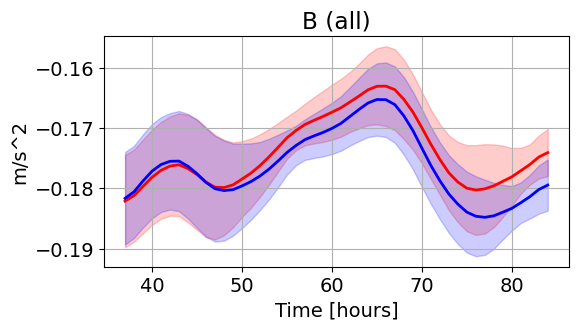

deep


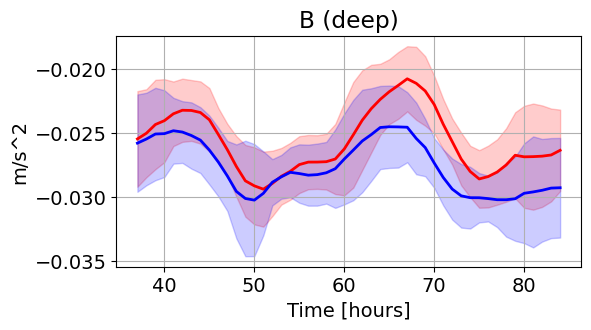

cong


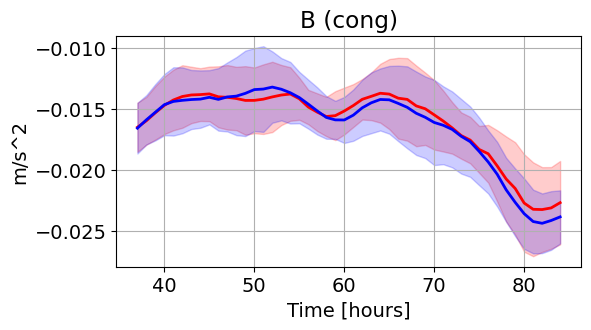

shall


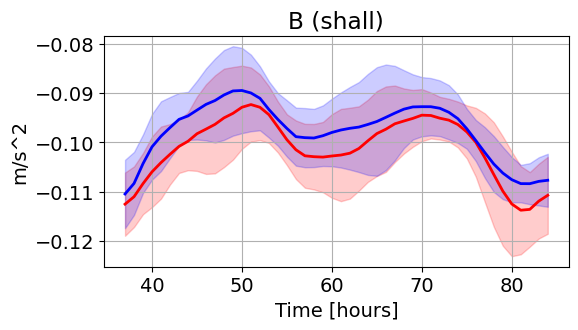

strat


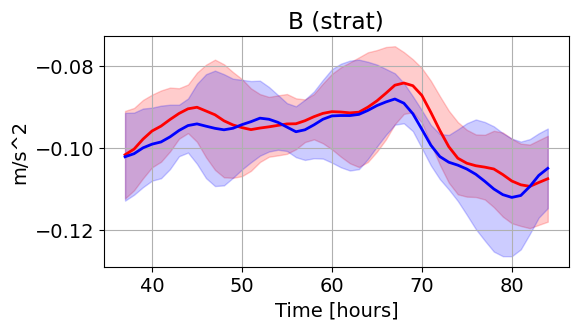

anvil


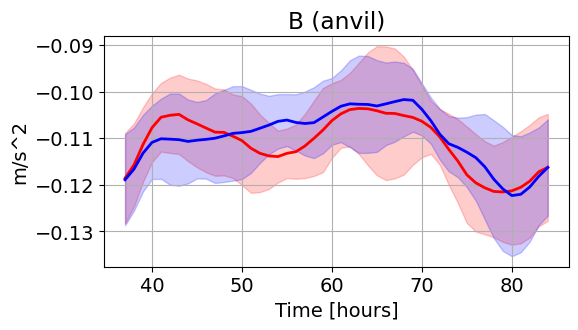

deepcong


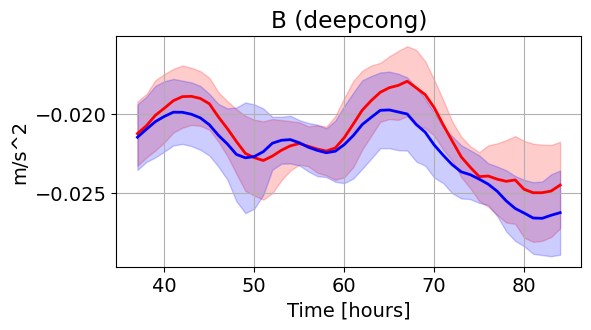

stratanv


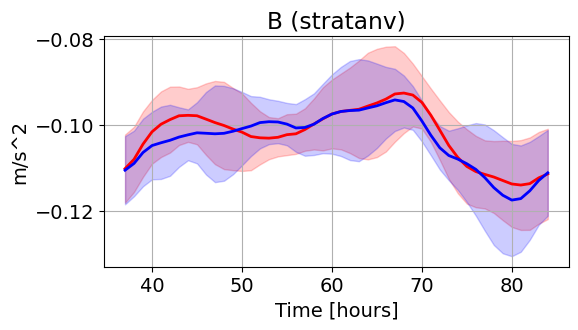

allrain


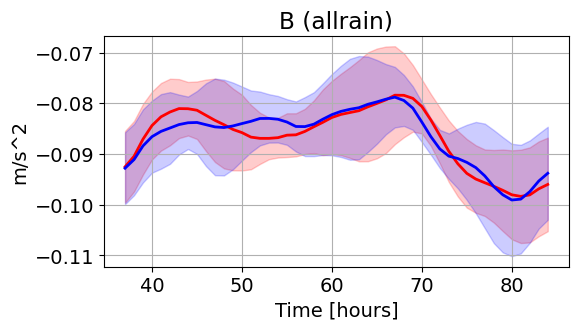

upward


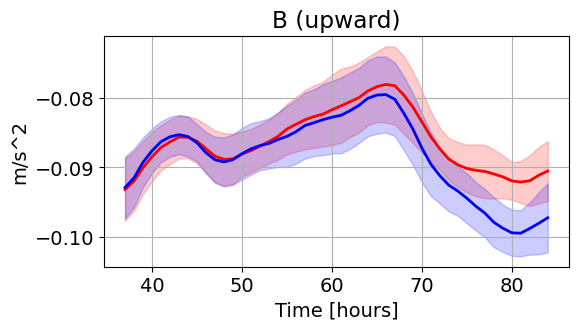

downward


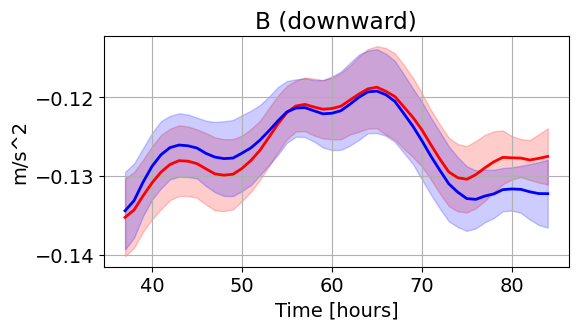

In [14]:
tshift = get_tshift(tests[itest])
times_ncrf = np.arange(tshift, nt[itest]+tshift, 1)

var0_ivar = buoy_sav[0, ...]
var1_ivar = buoy_sav[1, ...]
var0_ivar = var0_ivar[:, :, times_ncrf]
var1_ivar = var1_ivar[:, :, times_ncrf]
figtag = 'buoy'
ylabel = units[0]
title_tag = 'B'

for icond in range(ncond):

    fig_extra=condavg_label[icond]
    condtag=fig_extra #condavg_title[icond]
    print(fig_extra)

    var0 = np.copy(var0_ivar[:, icond, :])
    var1 = np.copy(var1_ivar[:, icond, :])

    # if figtag == 'mse':
    #     title_tag = '$h$'
    # elif figtag == 'vadv_mse':
    #     title_tag = 'VADV($h$) (Eul.)'

#----------------------------------------------------------------

    # Use Pandas to smooth via running mean
    var0 = pd.DataFrame(var0)
    var0 = var0.rolling(window=3, center=True, closed='both', axis=1).mean()
    var1 = pd.DataFrame(var1)
    var1 = var1.rolling(window=3, center=True, closed='both', axis=1).mean()

    # create figure
    fig = plt.figure(figsize=(6,3))
    ax = fig.add_subplot(111)

    ax.set_title(title_tag+' ('+condtag+')')#, fontsize=20)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Time [hours]')

    t_range=[times_ncrf[0], times_ncrf[-1]]
    # plt.xlim(t_range)

    color_t0 = 'red'
    color_t1 = 'blue'

    # Test 0

    mean_t0 = np.nanmean(var0, axis=0)
    std_t0 = np.nanstd(var0, axis=0)

    xdim = times_ncrf

    plt.plot(xdim, mean_t0, linewidth=2, label=tests[0].upper(), color=color_t0, linestyle='solid')
    plt.fill_between(xdim, mean_t0 + std_t0, mean_t0 - std_t0, alpha=0.2, color=color_t0)

    # Test 1

    mean_t1 = np.nanmean(var1, axis=0)
    std_t1 = np.nanstd(var1, axis=0)

    plt.plot(xdim, mean_t1, linewidth=2, label=tests[0].upper(), color=color_t1, linestyle='solid')
    plt.fill_between(xdim, mean_t1 + std_t1, mean_t1 - std_t1, alpha=0.2, color=color_t1)

    plt.grid()

    # plt.legend(loc="upper right")

    figdir2 = figdir+'all/'
    figname=figdir2+'tser_'+storm+'_'+figtag+'_'+fig_extra+'.png'
    plt.savefig(figname,dpi=200, facecolor='white', \
                bbox_inches='tight', pad_inches=0.2)
    plt.show()
    plt.close()

##### Time series showing the normalized change

all


/tmp/ipykernel_25490/568256178.py:48: RuntimeWarning: Mean of empty slice
  mean_t0 = np.nanmean(var0, axis=0)


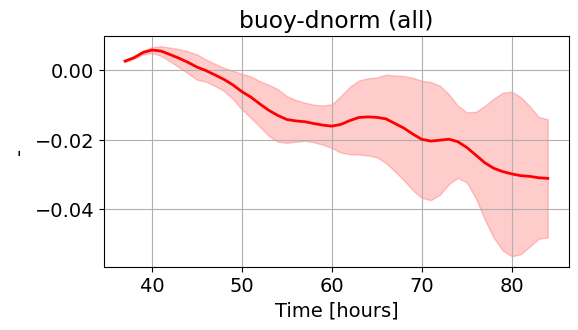

deep


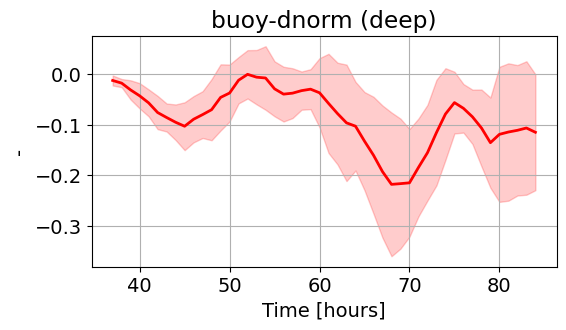

cong


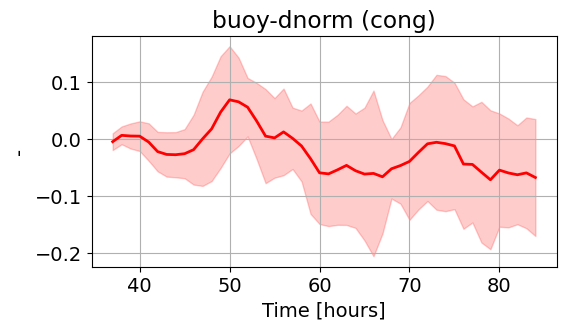

shall


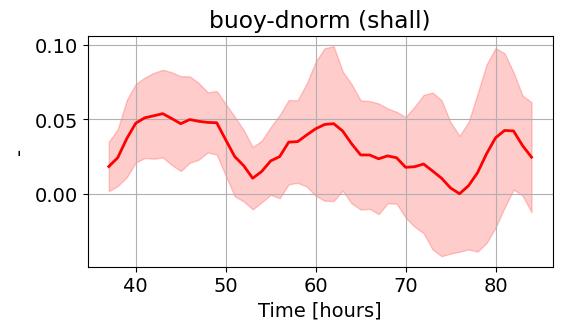

strat


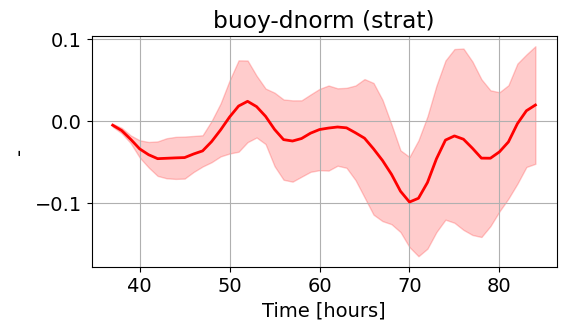

anvil


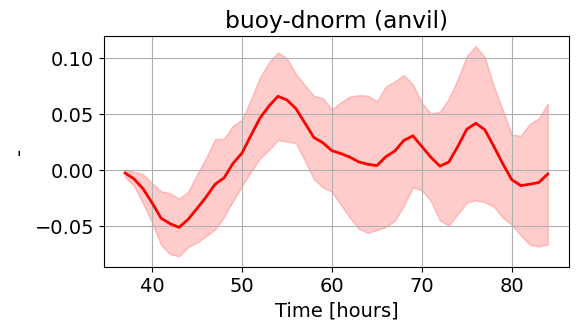

deepcong


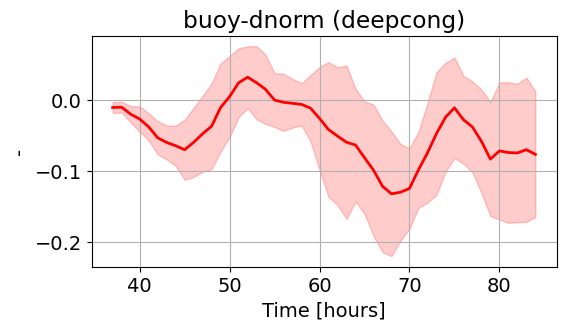

stratanv


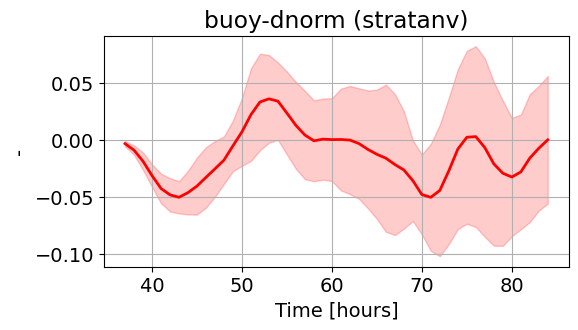

allrain


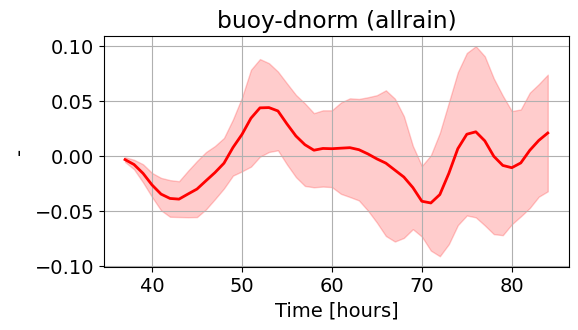

upward


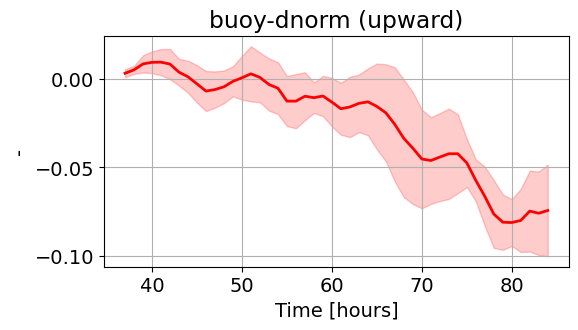

downward


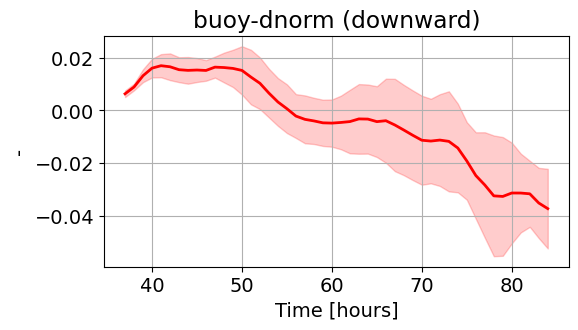

In [16]:
tshift = get_tshift(tests[itest])
times_ncrf = np.arange(tshift, nt[itest]+tshift, 1)

var0_ivar = buoy_sav[0, ...]
var1_ivar = buoy_sav[1, ...]
var0_ivar = var0_ivar[:, :, times_ncrf]
var1_ivar = var1_ivar[:, :, times_ncrf]

var_plot = (var0_ivar - var1_ivar) / var0_ivar

figtag = 'buoy-dnorm'
ylabel = '-' # units

for icond in range(ncond):

    fig_extra=condavg_label[icond]
    condtag=fig_extra #condavg_title[icond]
    print(fig_extra)

    var0 = np.copy(var_plot[:, icond, :])

    title_tag = figtag

#----------------------------------------------------------------

    # Use Pandas to smooth via running mean
    var0 = pd.DataFrame(var0)
    var0 = var0.rolling(window=3, center=True, closed='both', axis=1).mean()
    var1 = pd.DataFrame(var1)
    var1 = var1.rolling(window=3, center=True, closed='both', axis=1).mean()

    # create figure
    fig = plt.figure(figsize=(6,3))
    ax = fig.add_subplot(111)

    ax.set_title(title_tag+' ('+condtag+')')#, fontsize=20)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Time [hours]')

    t_range=[times_ncrf[0], times_ncrf[-1]]
    # plt.xlim(t_range)

    color_t0 = 'red'
    color_t1 = 'blue'

    # Test 0

    mean_t0 = np.nanmean(var0, axis=0)
    std_t0 = np.nanstd(var0, axis=0)

    xdim = times_ncrf

    plt.plot(xdim, mean_t0, linewidth=2, label=tests[0].upper(), color=color_t0, linestyle='solid')
    plt.fill_between(xdim, mean_t0 + std_t0, mean_t0 - std_t0, alpha=0.2, color=color_t0)

    plt.grid()

    # plt.legend(loc="upper right")

    figdir2 = figdir+'all/'
    figname=figdir2+'tser_'+storm+'_'+figtag+'_'+fig_extra+'.png'
    plt.savefig(figname,dpi=200, facecolor='white', \
                bbox_inches='tight', pad_inches=0.2)
    plt.show()
    plt.close()